# Module 2 Final Project Submission - Question 1 of 4

* Student name: **Chelsea Power**
* Student pace: **part time**
* Scheduled project review date/time: **May 10, 2019 at 3:30 pm ET**
* Instructor name: **Joe San Pietro**
* Blog post URL: **TBD**

### Part I: Do discounts have a statistically significant effect on the number of products customers order?

In [1]:
# Import required libraries
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as _stats
from scipy import stats

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Connect an engine and connect to the Northwind database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)

# Create session to execute SQL commands
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

# Extract Order Detail data as a pandas dataframe using a SQL query
df = pd.read_sql_query('''
 SELECT * 
 FROM OrderDetail
 ''', engine)

2019-05-10 12:39:36,576 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-10 12:39:36,577 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 12:39:36,578 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-10 12:39:36,579 INFO sqlalchemy.engine.base.Engine ()
2019-05-10 12:39:36,581 INFO sqlalchemy.engine.base.Engine 
 SELECT * 
 FROM OrderDetail
 
2019-05-10 12:39:36,582 INFO sqlalchemy.engine.base.Engine ()


In [2]:
# Display OrderDetail as a panda dataframe
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Split the data into two separate groups to test the difference.

In [3]:
# Create control group: customers who did not receive a discount
control = df[df['Discount'] == 0]
control = control['Quantity']

# Create experimental group: customers who received a discount
experimental = df[df['Discount'] != 0]
experimental = experimental['Quantity']

In [4]:
# Calculate the difference between distribution means
control.mean()
experimental.mean()
experimental.mean() - control.mean()

5.394523243866239

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


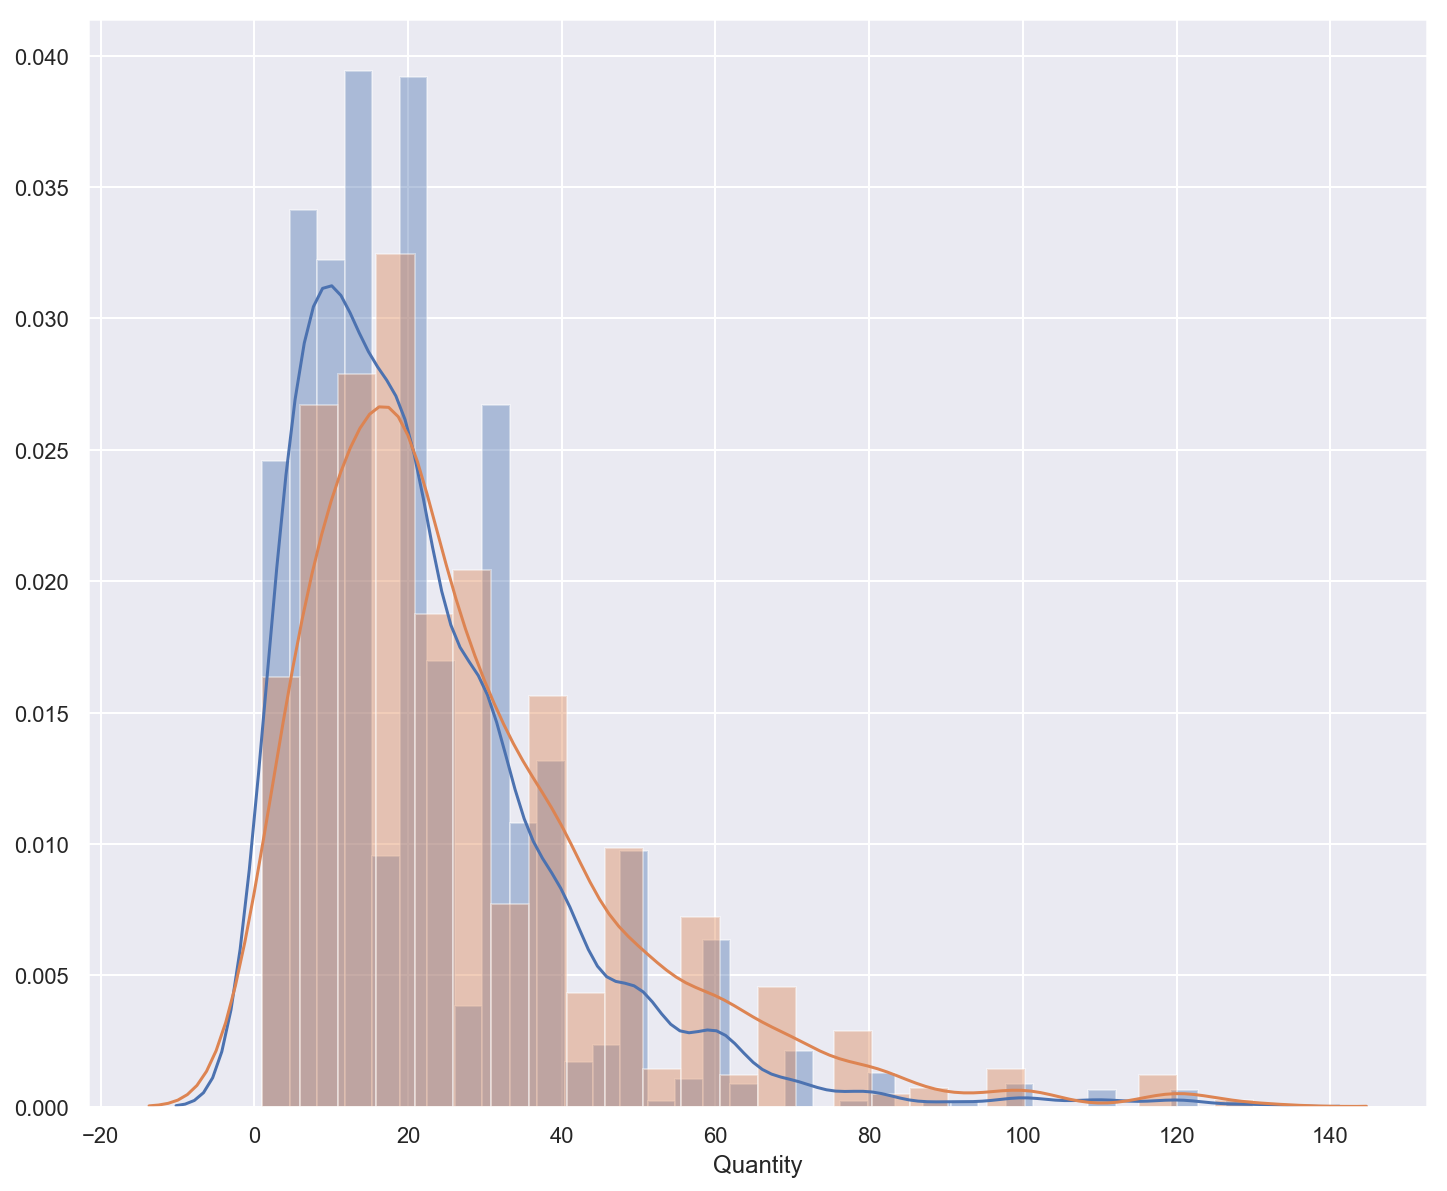

In [5]:
# Plot data and run normality test
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control) # Blue distribution
sns.distplot(experimental) # Orange distribution

### Create a sample distribution of the sample mean to continue the hypothesis testing

In [6]:
# Create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# Create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# Combine functions to create a sample distribution
# Create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    return sample_dist

# Create sample distributions of sample mean for control and target
control_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(experimental)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


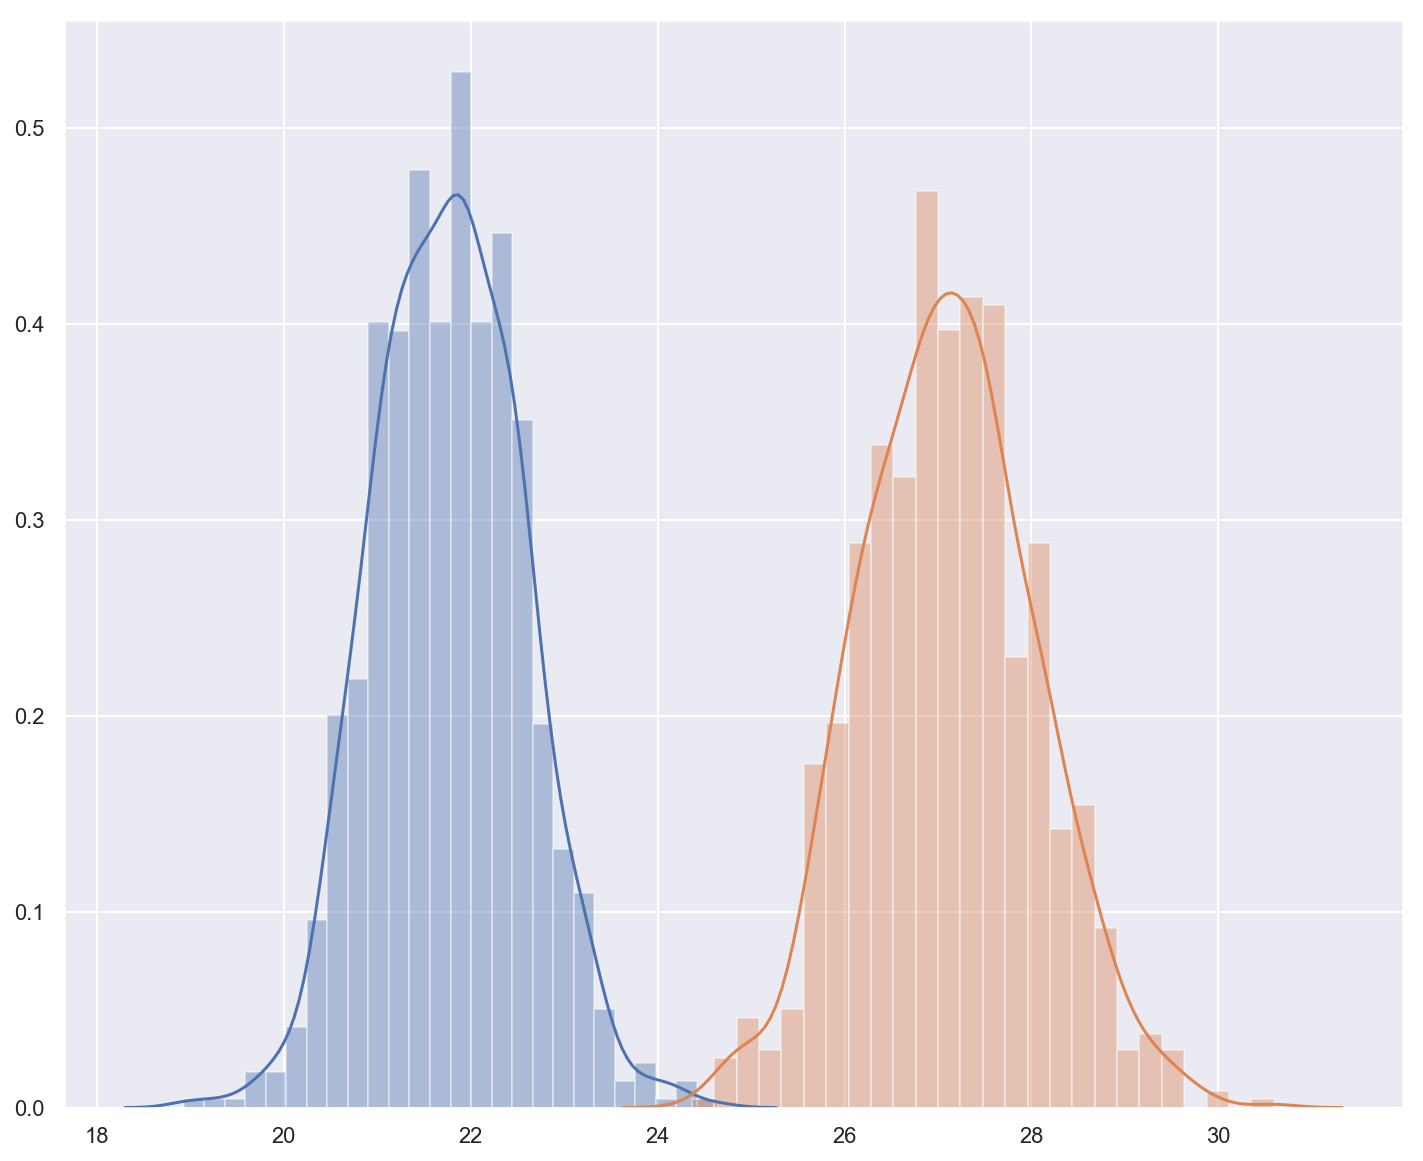

In [7]:
# Plot sample Distribution
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(control_sample) # Blue distribution
sns.distplot(exp_sample) # Orange distribution

In [8]:
# Test whether variances are equal
np.var(control) == np.var(experimental)

False

### Welch’s t-test

Using this test since the data is not normally distributed and the samples do not have an equal variance.

In [9]:
def welch_t(control, experimental):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = control.mean() - experimental.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(control.var(ddof=1)/control.size + experimental.var(ddof=1)/experimental.size)
    
    return numerator/denominator

welch_t(control, experimental)

-6.239069142123973

In [10]:
# Calculate the p_value
stats.ttest_ind(control, experimental, equal_var=False)

Ttest_indResult(statistic=-6.239069142123973, pvalue=5.65641429030433e-10)

Since the statistic is -6.23 and p-value is 5.6 (which is a two-tailed p-value), if we divide by two to obtain the one-tail p-value, the p-value is 2.82820714. 

**Since p > α (0.05), the null hypothesis is accepted.**

In [11]:
# Calculate Degrees of freedom
def welch_df(control, experimental):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = control.var(ddof=1) 
    s2 = experimental.var(ddof=1)
    n1 = control.size
    n2 = experimental.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(control, experimental)

1561.7678231942148

### T-distribution with Increasing number of trials

/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead

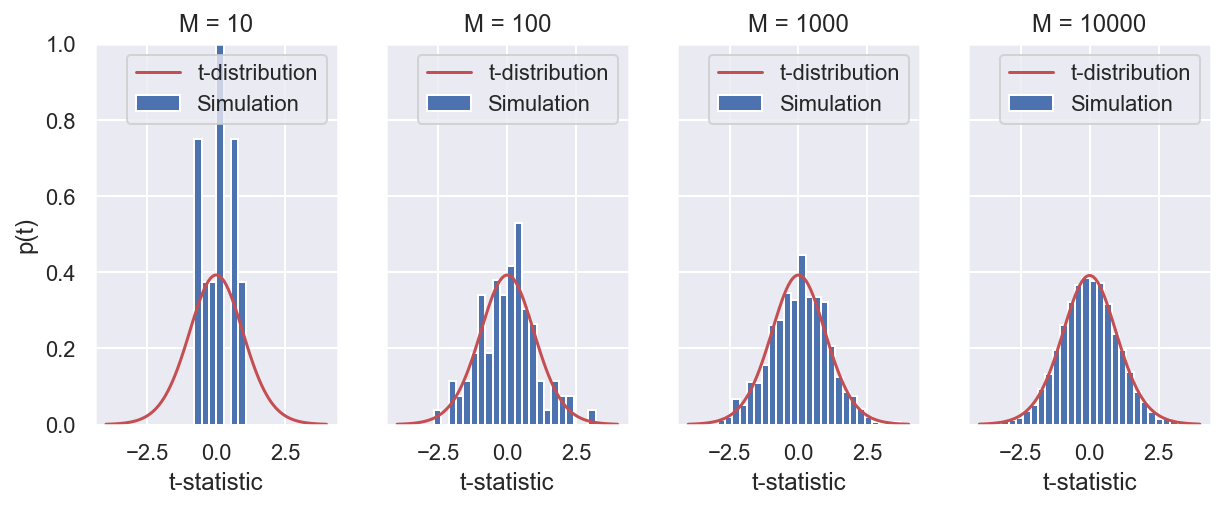

In [12]:
np.random.seed(10)

N = 10 # Sample size
mu, sig = 2, 1.5
fig, axes = plt.subplots(figsize=(10,3.5), ncols=4, sharey=True)
for ax, M in zip(axes, [10, 100, 1000, 10000]):

    # Generate samples as arrays of shape M*N
    control = np.random.randn(M, N)*sig + mu
    experimental = np.random.randn(M, N)*sig + mu

    # Calculate a set of Welch t values from samples and plot a histogram
    ts = np.array([welch_t(control_i, experimental_i) for control_i, experimental_i in zip(control, experimental)])
    ax.hist(ts, range=(-4,4), bins=30, normed=True, label='Simulation')
    
    # Calculate Welch df for plotting t distribution
    df = welch_df(control[0,:], experimental[0,:])
    x = np.linspace(-4, 4, 100)
    ax.plot(x, stats.t.pdf(x, df), color='r', label='t-distribution')

    # Label the plot and axes
    ax.set_title("M = {}".format(M))
    ax.set_ylim(0, 1)
    ax.set_xlabel("t-statistic")
    _ = ax.legend()
    axes[0].set_ylabel("p(t)")

As the number of simulations gets larger, the distribution of t-statistics becomes closer and closer to the t-distribution with degrees of freedom calculated from the data. We can therefore use the t-distribution as an approximation of this process, as if we had actually performed the simulation infinite times.

In [13]:
# Calculate welch-t and degree of freedom from these samples using functions developed earlier:
t = welch_t(experimental, control)
df = welch_df(experimental, control)
t,df

(0.7998810385191989, 199997.999898755)

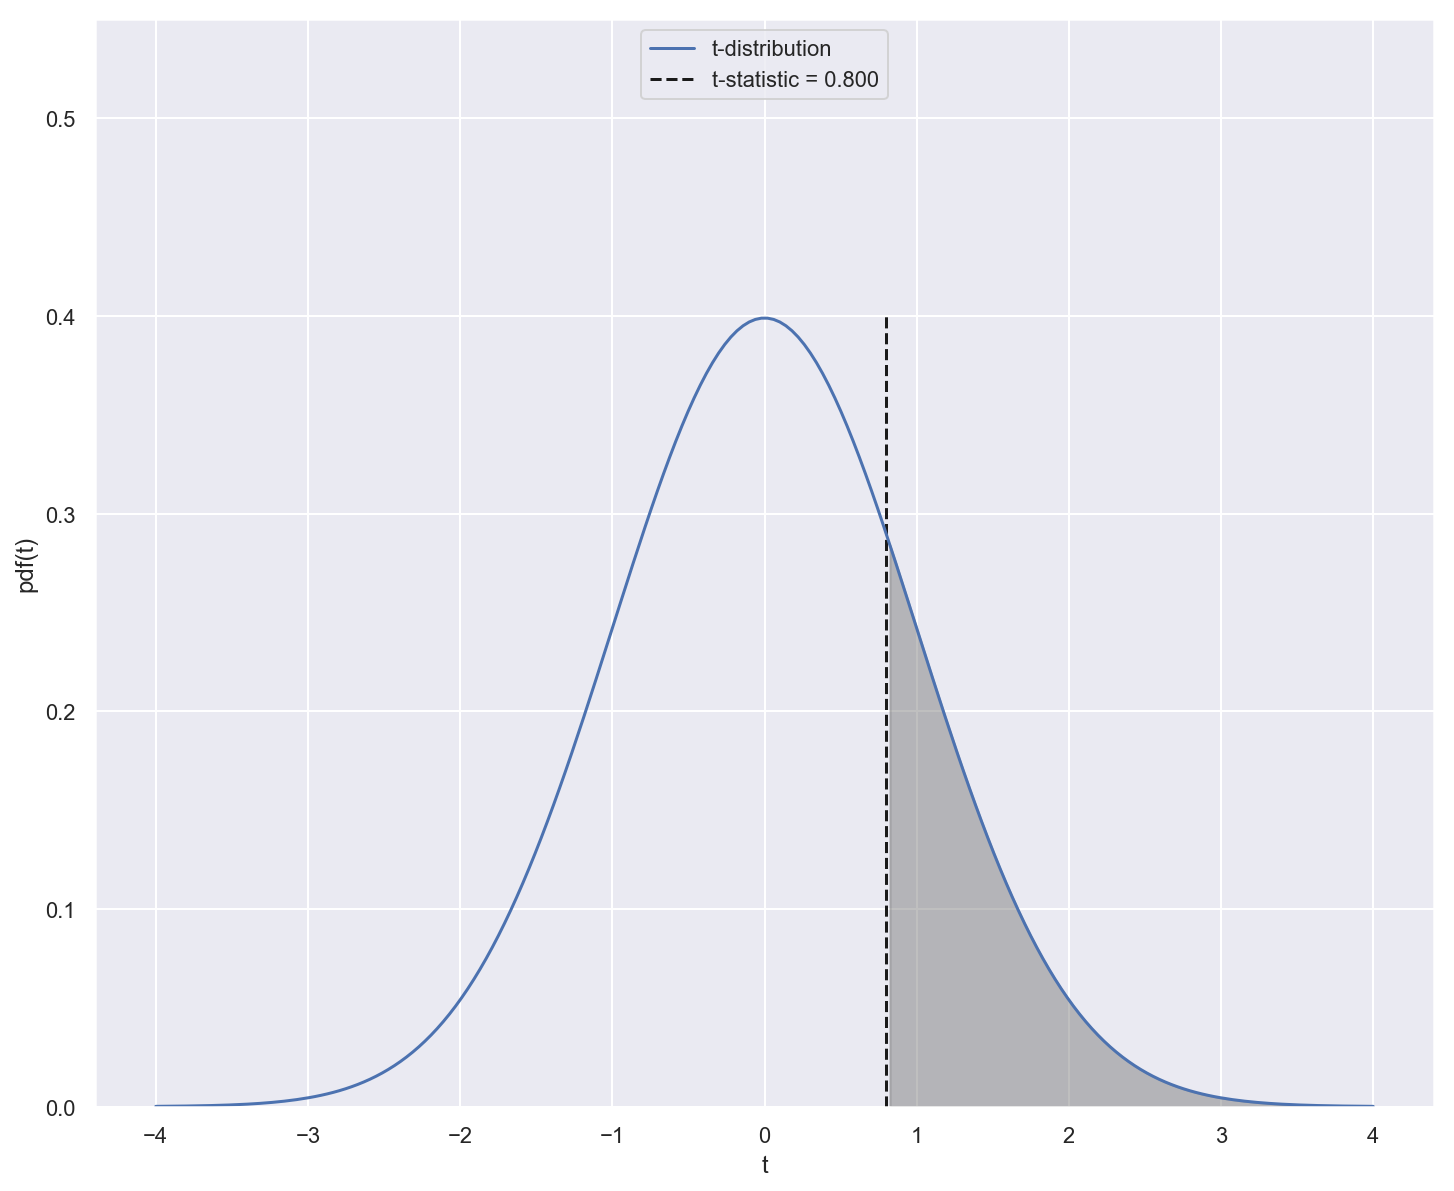

In [14]:
fig, ax = plt.subplots()
x = np.linspace(-4, 4, 200)
t_dist = stats.t.pdf(x, df)
ax.plot(x, t_dist, label='t-distribution')
ax.vlines(t, 0, 0.4, linestyles='--', color='k', 
          label='t-statistic = {:.3f}'.format(t))
ax.set_ylabel('pdf(t)')
ax.set_xlabel('t')
ax.set_ylim(0, 0.55)
ax.legend(loc=9)
ax.fill_between(x, 0, t_dist, where=(x >= t), color='grey', alpha=0.5)

In [15]:
#Calculate the shaded area is with the cumulative density function (CDF)
p = 1 - stats.t.cdf(t, df)
p

0.21189033737715013

There is a 21% probability we would see t equal to or greater than what we saw from our data. We can also reject the null hypothesis since p is less than 0.05.

### Effect Size

Measure the magnitude of the difference using **Cohen’s d** where values of 0 - 0.2 have little or no effect and values > 0.8 have a large effect size.

    d = effect size (difference of means) / pooled standard deviation

In [16]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [17]:
print("Cohen's d:", Cohen_d(np.array(exp_sample), np.array(control_sample)))

Cohen's d: 6.164107071609803


Based on **Cohen's d**, the discount amount has a statistically significant effect on quantity of products ordered.

### Part II: What levels of discount amount has statistically significant effect on the quantity of products ordered? Does a 5% discount have the same effect as a 20% discount? 

In [20]:
# Extract Order Detail data as a pandas dataframe using a SQL query
df = pd.read_sql_query('''
 SELECT * 
 FROM OrderDetail
 ''', engine)

2019-05-10 12:40:30,504 INFO sqlalchemy.engine.base.Engine 
 SELECT * 
 FROM OrderDetail
 
2019-05-10 12:40:30,505 INFO sqlalchemy.engine.base.Engine ()


### Perform a one-way ANOVA tests for significant differences between multiple groups. 

Formula:

```Control_Column ~ C(factor_col1) + factor_col2 + C(factor_col3) + ... + X```

In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

discount = df.Discount
quantity = df.Quantity

formula = 'quantity ~ C(discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


The result **p (4.7e-09) < α**, so we reject the null hypothesis. 

Perform multiple comparison analysis to look at all possible pair means to determine if **discount amounts of 5, 15, 20 and 25%** produce a statistically significant effect on the mean quantity of product ordered.

In [25]:
#Tukey's range test - compares all possible pairs and we can use it to precisely 
#identify difference between two means that's greater than the expected standard error.
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['Quantity'], df['Discount'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

Results of **’reject = True’** means that a significant difference has been observed.